In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
path = os.getcwd()

In [2]:
# Global imports
import argparse
import shutil
import pickle
from pprint import pprint
import random
import numpy as np
from functools import partial
## torch
import torch
import torch.distributed



隐藏输出

In [3]:
from IPython.display import HTML
import random
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

获取模型和配置文件

In [4]:
# Parameters
torchscript_path = '/home/lyh/data/EDIT_NETWORK/checkpoints/WrappedDistributedTorchTrainable_52cdc_00000_0_2023-07-02_10-01-14/checkpoint_000050/checkpoint.pkl'
script_path='/home/lyh/data/EDIT_NETWORK/checkpoints/WrappedDistributedTorchTrainable_52cdc_00000_0_2023-07-02_10-01-14/params.json'
import sys
sys.path.append("..")
sys.path.append("../engine")
from models.seqnext import SeqNeXt


import json

with open(script_path,'r',encoding = 'utf-8') as fp:
 
    print(type(fp))  #输出结果是 <class '_io.TextIOWrapper'> 一个文件类对象
    # load()函数将fp(一个支持.read()的文件类对象，包含一个JSON文档)反序列化为一个Python对象
    config = json.load(fp)
    print(type(config))  #输出结果是 <class 'dict'> 一个python对象,json模块会根据文件类对象自动转为最符合的数据类型,所以这里是dict
# Data loading code

config['debug']=True



<class '_io.TextIOWrapper'>
<class 'dict'>


In [5]:

# # Device
# device = torch.device('cuda')
# # Load torchscript version of model
# print(device)

# model = SeqNeXt(config, oim_lut_size=483, device=device)
# checkpoint = torch.load(torchscript_path, map_location='cpu')
# state_dict = checkpoint['model']
#         # Delete keys with potentially conflicting params
#         # Load state dict into the model
# def _del_key(state_dict, key):
#     if key in state_dict:
#         del state_dict[key]        
# _del_key(state_dict, 'roi_heads.reid_loss.lut')
# _del_key(state_dict, 'roi_heads.reid_loss.cq')
# _del_key(state_dict, 'gfn.reid_loss.lut')
# _del_key(state_dict, 'gfn.reid_loss.cq')
# _del_key(state_dict, 'roi_heads.gfn.reid_loss.lut')
# _del_key(state_dict, 'roi_heads.gfn.reid_loss.cq')
# model.load_state_dict(state_dict, strict=False)
# model.to('cuda')
# model.eval()
# # torchscript_path = '/home/lyh/data/EDIT_NETWORK/checkpoints/prw_final_convnext-base_e30.torchscript.pt'
# # model = torch.jit.load(torchscript_path)
# # hide_toggle()

引入测试数据集

In [6]:
import engine.transform as transform
import engine.dist_utils as dist_utils
## engine
## data
from data import det_utils

def get_test_loader(config):
    # Use ImageNet stats to standardize the data
    stat_dict = {
        'mean': config['image_mean'],
        'std': config['image_std'],
    }

    # Set transform
    ## IFN transform
    # if config['aug_mode'] == 'wrs':
    #     test_transform = transform.get_transform_wrs(train=False, stat_dict=stat_dict)
    # elif config['aug_mode'] == 'rrc':
    #     test_transform = transform.get_transform_rrc(train=False, stat_dict=stat_dict)
    # elif config['aug_mode'] == 'rrc2':
    #     test_transform = transform.get_transform_rrc2(train=False, stat_dict=stat_dict)
    test_transform = transform.get_transform_rrc3(train=True, stat_dict=stat_dict)
    print(test_transform.albu_transform)
    
    # Get dataset
    test_dataset, _ = det_utils.get_coco(
        config['dataset_dir'], dataset_name=config['dataset'], image_set=config['test_set'], transforms=test_transform)

    # Test sampler
    if config['debug']:
        test_sampler = torch.utils.data.SequentialSampler(test_dataset)
    else:
        test_sampler = torch.utils.data.distributed.DistributedSampler(test_dataset)

    # Get test dataset objects
    retrieval_dir = os.path.join(config['dataset_dir'], 'retrieval')
    test_sampler = det_utils.TestSampler(config['test_set'], test_dataset, retrieval_dir,
        config['retrieval_name_list'])
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1,
        sampler=test_sampler, num_workers=config['workers'],
        collate_fn=dist_utils.collate_fn)

    #
    return test_loader,test_dataset

Compose([
  WindowResize(always_apply=False, p=1, min_size=900, max_size=1500, interpolation=1),
  PadIfNeeded(always_apply=False, p=1.0, min_height=1536, min_width=1536, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=[-2.11790393 -2.03571429 -1.80444444], mask_value=None),
  OneOf([
    RandomFocusedCrop2(always_apply=False, p=1.0, height=512, width=512),
    RandomSizedBBoxSafeCrop(always_apply=False, p=1.0, erosion_rate=0.0, height=512, width=512, interpolation=1),
  ], p=1),
  HorizontalFlip(always_apply=False, p=0.5),
  ToGray(always_apply=False, p=0.5),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': ['category_ids', 'person_id', 'id', 'iou_thresh', 'is_known'], 'min_area': 0.0, 'min_visibility': 0.6, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
      # Images  # Known ID  # Unknown ID
test      6112         544          5935
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
/home/lyh/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

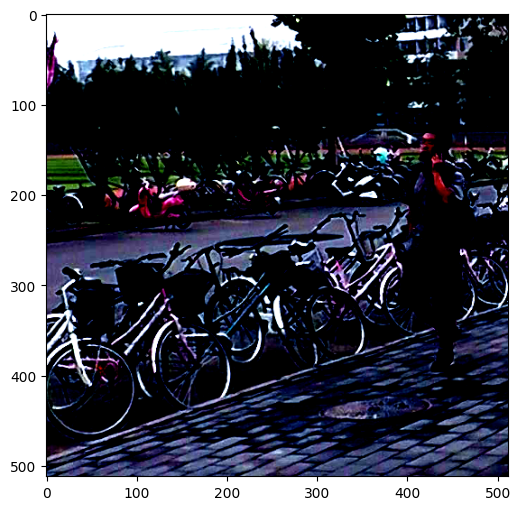

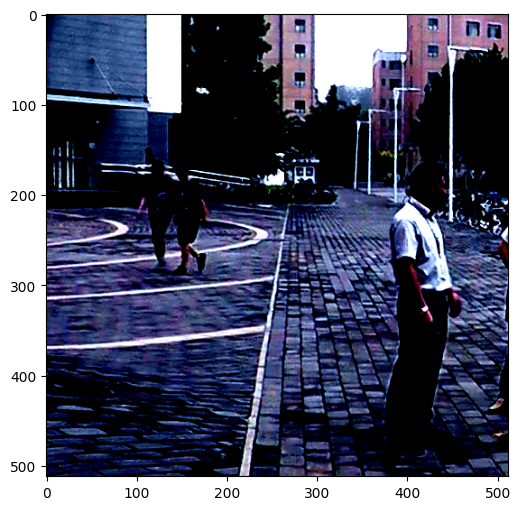

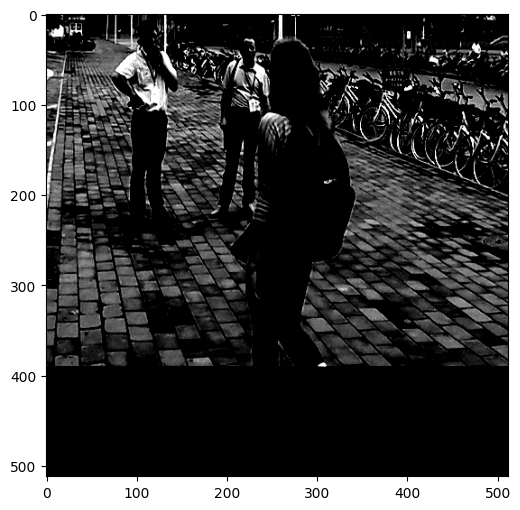

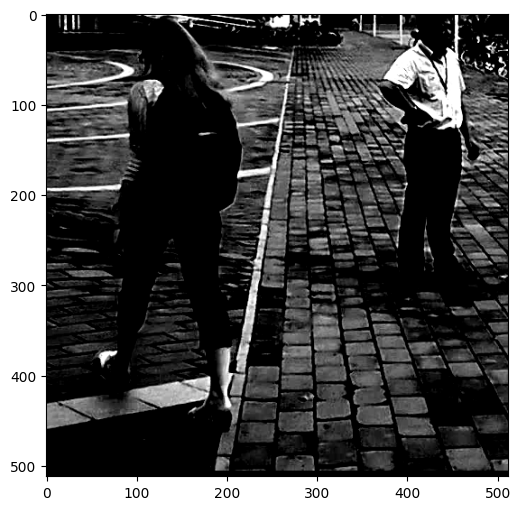

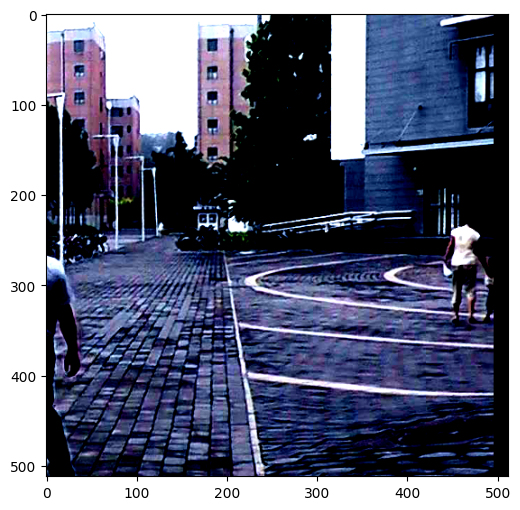

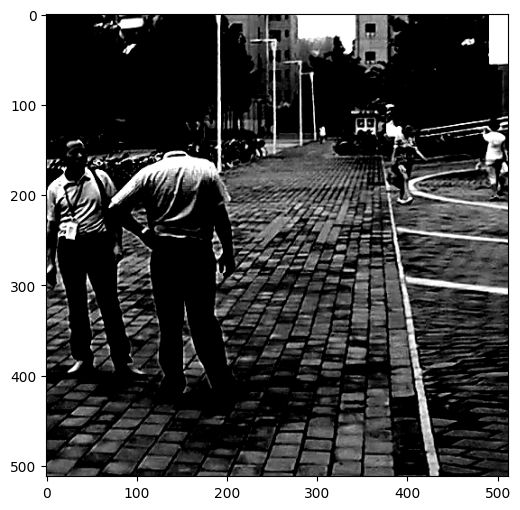

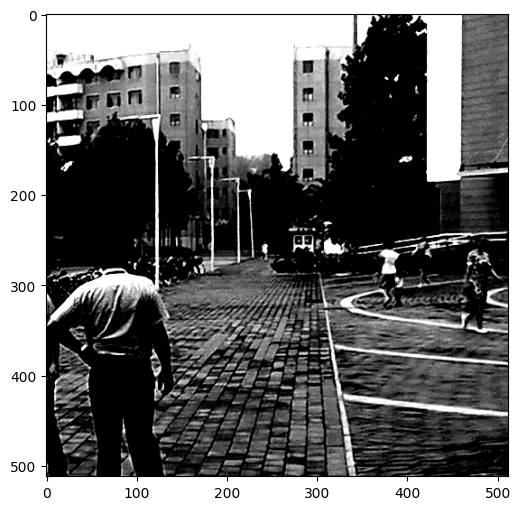

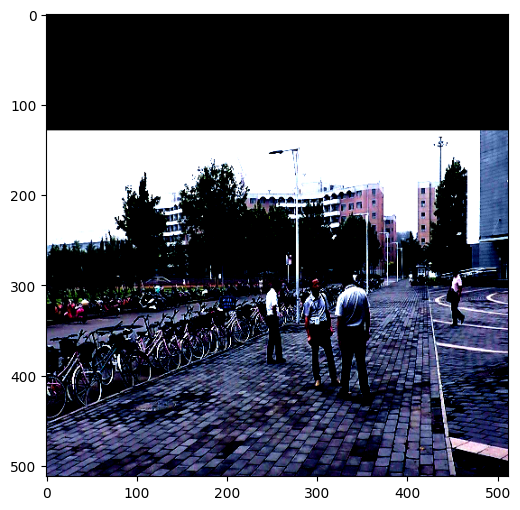

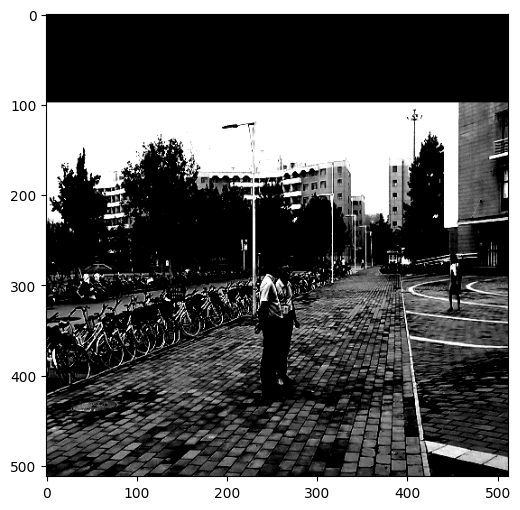

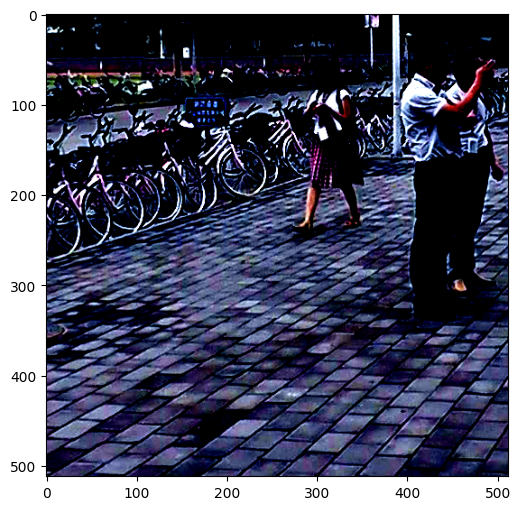

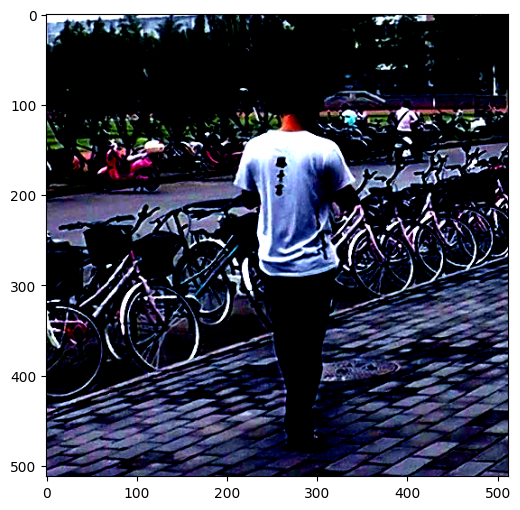

In [7]:
# Libs for data pre-processing
import cv2
import numpy as np
from albumentations.augmentations.geometric import functional as FGeometric
import torchvision.transforms.functional as TF

# Libs for loading images
import os
import urllib.request
from PIL import Image
import ssl
## Avoid SSL error
ssl._create_default_https_context = ssl._create_unverified_context

# Libs for visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

test_loader,test_dataset=get_test_loader(config)
print(test_loader)
i=0
for images, targets in test_loader:
    i+=1
    fig, ax = plt.subplots(figsize=(6, 6))
    # Setup labels
    # Show the image
    ax.imshow(images[0].permute(1, 2, 0).cpu())
    if(i>10):
        break

In [ ]:
# Global imports
import collections
import torch
import torch.nn.functional as F
import os
import json
import numpy as np
from pprint import pprint
from sklearn.metrics import average_precision_score
from tqdm import tqdm
from ray.tune.integration.torch import is_distributed_trainable
from torchvision.ops import boxes as box_ops
# Package imports
import engine.utils as engine_utils
# Define objects to neatly store results

QueryLookupEntry = collections.namedtuple('QueryLookupEntry',
    ['image_id', 'person_id', 'embedding', 'box', 'idx'],
    defaults=[None, None, None, None, None],
)

ImageLookupEntry = collections.namedtuple('ImageLookupEntry',
    ['id', 'person_ids', 'iou_thresh', 'boxes', 'scores', 'embeddings', 'features'],
)

DetectionLookupEntry = collections.namedtuple('DetectionLookupEntry',
    ['boxes', 'scores', 'embeddings', 'labels'],
)

RetrievalLookupEntry = collections.namedtuple('RetrievalLookupEntry',
    ['sims', 'boxes', 'iou', 'gfn_scores'],
    defaults=[None, None, None, None],
)

Protocol = collections.namedtuple('Protocol',
    ['partition_name', 'name', 'data']
)

RetrievalBox = collections.namedtuple('RetrievalBox',
    ['image_id', 'box', 'score', 'match', 'query'],
    defaults=[None, None, None, None, None],
)


计算embedding

In [ ]:
@torch.no_grad()
def get_model_output(model, data_loader, use_gfn=False, use_amp=False, device='cuda'):
    # Put model in eval mode
    model.eval()

    # Compute and gather detections and ground truth embeddings
    query_lookup, image_lookup, detection_lookup = run_model(model, data_loader,
        use_amp=use_amp, device=device)

    # Combine all query embeddings into a single tensor for easy computation of cosine similarity
    query_embeddings, query_image_feat_list = get_query_embeddings(query_lookup, image_lookup)

    # Compute GFN scores
    gfn_score_dict = get_gfn_scores(model, image_lookup, query_embeddings, query_image_feat_list,
        use_gfn=use_gfn, device=device)

    # Return results
    return query_lookup, query_embeddings, image_lookup, detection_lookup, gfn_score_dict



def run_model(model, data_loader, use_amp=False, device='cuda'):
    # Compute and gather detections and ground truth embeddings
    print('==> Computing detections and embeddings')
    with torch.cuda.amp.autocast(enabled=use_amp):
        image_lookup = {}
        query_lookup = {}
        detection_lookup = {}
        for iter_idx, (images, targets) in tqdm(enumerate(data_loader), ncols=0, total=len(data_loader)):
            images, targets = engine_utils.to_device(images, targets, device)
            outputs = model(images, targets, inference_mode='both')
            # for output in outputs:
            #     print(output['gt_emb'].shape)
            embeddings = torch.cat([output['gt_emb'] for output in outputs])
            assert len(targets) == len(outputs)
            # XXX
            for target, output in zip(targets, outputs):
                image_id = target['image_id'].item()
                image_lookup[image_id] = ImageLookupEntry(
                    id=target['id'], person_ids=target['person_id'], iou_thresh=target['iou_thresh'].cpu(),
                    boxes=target['boxes'], scores=torch.ones(target['boxes'].size(0)), embeddings=embeddings,
                    features=output['scene_emb'],
                )
                detection_lookup[image_id] = DetectionLookupEntry(
                    boxes=output['det_boxes'],
                    scores=output['det_scores'],
                    labels=output['det_labels'],
                    embeddings=output['det_emb'],
                )
                #
                assert len(target['id']) == len(target['person_id']) == len(embeddings)
                for _id, _person_id, _box, _embedding in zip(target['id'].tolist(), target['person_id'], target['boxes'], embeddings.unsqueeze(1)):
                    if _id in data_loader.sampler.query_id_list:
                        query_lookup[_id] = QueryLookupEntry(image_id=image_id, person_id=_person_id,
                            embedding=_embedding, box=_box)
    #
    return query_lookup, image_lookup, detection_lookup


def get_query_embeddings(query_lookup, image_lookup):
    # Combine all query embeddings into a single tensor for easy computation of cosine similarity
    query_embedding_list = []
    query_image_feat_list = []
    for _id_idx, (_id, _query) in enumerate(query_lookup.items()):
        _embedding = _query.embedding
        query_embedding_list.append(_embedding)
        query_lookup[_id] = query_lookup[_id]._replace(idx=_id_idx)
        query_image_id = query_lookup[_id].image_id
        query_image_feat = image_lookup[query_image_id].features
        query_image_feat_list.append(query_image_feat)
    query_embeddings = torch.cat(query_embedding_list, dim=0)
    return query_embeddings, query_image_feat_list

def get_gfn_scores(model, image_lookup, query_embeddings, query_image_feat_list, use_gfn=False, device='cuda'):
    # Compute GFN scores
    if use_gfn:
        ## Pack feats together for GFN or QFN
        query_img_feat_mat = torch.cat(query_image_feat_list, dim=0)
        gallery_img_feat_mat = torch.cat([image_lookup[query_id].features for query_id in image_lookup], dim=0)
        ## Get GFN
        if is_distributed_trainable():
            gfn = model.module.gfn
        else:
            gfn = model.gfn
        ## Get scores
        gfn_scores = gfn.get_scores(query_embeddings, query_img_feat_mat, gallery_img_feat_mat)
        #print(gfn_scores.min(), gfn_scores.max())
        gfn_score_dict = dict(zip(list(image_lookup.keys()), gfn_scores.T.to(device)))
    else:
        gfn_score_dict = None
    return gfn_score_dict

In [ ]:
def _match_boxes(match_quality_matrix, iou_thresh):
    """
    Note: This function mimics other person search codes,
    and does not implement the standard COCO box matching
    algorithm.
    """
    # Zero out any pairs with IoU < thresh
    match_quality_matrix[match_quality_matrix<iou_thresh] = 0.0
    # For each det, keep largest IoU of all GT
    max_gt_idx = match_quality_matrix.argmax(dim=1, keepdim=True)
    max_gt_mask = torch.zeros_like(match_quality_matrix, dtype=torch.bool)
    max_gt_mask.scatter_(1, max_gt_idx, True)
    # For each GT, keep largest IoU of all det
    max_det_idx = match_quality_matrix.argmax(dim=0, keepdim=True)
    max_det_mask = torch.zeros_like(match_quality_matrix, dtype=torch.bool)
    max_det_mask.scatter_(0, max_det_idx, True)

    ## Set non-max elems to 0
    match_quality_matrix[~max_gt_mask] = 0.0
    match_quality_matrix[~max_det_mask] = 0.0
    # Get indices
    det_idx, gt_idx = torch.where(match_quality_matrix)

    return det_idx, gt_idx
    
def evaluate_detection_orig(partition_name, detection_lookup, image_lookup, query_embeddings,
    gfn_score_dict=None, det_thresh=0.5, iou_thresh=0.5):
    num_gt_match, num_gt_tot = 0, 0
    num_det_tot = 0
    det_scores_list = []
    det_matches_list = []
    retrieval_lookup = {}
    error_image_lsit=[]

    for image_id in tqdm(image_lookup):
        # Unpack detections for this image
        detection = detection_lookup[image_id]
        det_boxes = detection.boxes
        det_scores = detection.scores
        det_embeddings = detection.embeddings
        num_det_tot += det_boxes.shape[0]
        # Unpack GT for this image
        gt = image_lookup[image_id]
        gt_boxes = gt.boxes
        gt_person_ids = gt.person_ids
        num_gt_tot += gt_boxes.shape[0]
        # Store GFN scores
        if gfn_score_dict is not None:
            retrieval_lookup[image_id] = RetrievalLookupEntry(gfn_scores=gfn_score_dict[image_id])
        else:
            retrieval_lookup[image_id] = RetrievalLookupEntry()

        # Compute detection results
        if det_boxes.shape[0] > 0:
            # Filter only detections with high enough score
            det_mask = det_scores >= det_thresh
            good_det_scores = det_scores[det_mask]
            good_det_boxes = det_boxes[det_mask]
            good_det_embeddings = det_embeddings[det_mask]
            # Match detections with GT boxes
            match_quality_matrix = box_ops.box_iou(good_det_boxes, gt_boxes)
            device=torch.device('cuda')
            det_idx, gt_idx = _match_boxes(match_quality_matrix.clone(), iou_thresh)

            # print(det_idx.device)
            # print(gt_idx.device)
            det_idx=det_idx.to(device)
            gt_idx=gt_idx.to(device)

            #匹配上的框小于检测出来的框说明发生了漏检情况
            if(gt_idx.shape[0]<gt_boxes.shape[0]):
                error_image_lsit.append(image_id)
            
            num_gt_match += gt_idx.shape[0]
            det_scores_list.append(good_det_scores)
            det_matches = torch.zeros(len(good_det_boxes))
            det_matches[det_idx] = 1
            det_matches_list.append(det_matches)
            # Store detected person_ids
            
            det_person_ids = torch.full((len(good_det_boxes),), -1, dtype=torch.long)
            det_person_ids=det_person_ids.to(device)
            gt_person_ids=gt_person_ids.to(device)

            det_person_ids[det_idx] = gt_person_ids[gt_idx]
            # Compute cosine similarity used later for retrieval ranking
            ## We assume the embeddings are already normalized, and have other scores incorporated after normalization:
            ## confidence-weighted similarity from the detector
            det_sims = torch.mm(
                query_embeddings,
                good_det_embeddings.T,
            )
            # Store everything in retrieval dict
            assert det_matches.shape[0] == det_person_ids.shape[0] == det_sims.shape[1]
            retrieval_lookup[image_id] = retrieval_lookup[image_id]._replace(sims=det_sims, boxes=good_det_boxes, iou=match_quality_matrix)
    #
    print('num_det_tot:', num_det_tot)
    print('gt/tot:', num_gt_match, num_gt_tot)
    det_recall = num_gt_match / num_gt_tot
    # Compute AP@0.5
    if len(det_scores_list) > 0:
        ## Combine all scores, labels, and clean any invalid scores
        det_scores = np.nan_to_num(torch.cat(det_scores_list).tolist(), posinf=0, neginf=0)
        det_matches = torch.cat(det_matches_list).tolist()
        ## Compute AP@0.5
        det_ap = average_precision_score(det_matches, det_scores) * det_recall
    else:
        det_ap = 0
    metric_dict = {
        f'{partition_name}_ap@0.5': det_ap,
        f'{partition_name}_recall@0.5': det_recall,
    }
    #
    return metric_dict, retrieval_lookup,error_image_lsit


预测代码主体

In [ ]:

# Get model output
query_lookup, query_embeddings, image_lookup, detection_lookup, gfn_score_dict = get_model_output(model, test_loader,
        use_gfn=config['use_gfn'], use_amp=config['use_amp'], device=device)
print("ok")
hide_toggle()


In [ ]:
import pickle

def save(v,filename):
  f=open(filename,'wb')
  pickle.dump(v,f)
  f.close()
  return filename

def load(filename):
  f=open(filename,'rb')
  r=pickle.load(f)
  f.close()
  return r


In [ ]:
# print(query_lookup.keys())

In [ ]:
# torch.save (query_lookup, 'query_lookup.pt')
# torch.save (query_embeddings, 'query_embeddings.pt')
# torch.save (image_lookup, 'image_lookup')
# torch.save (detection_lookup, 'detection_lookup') 
# torch.save (gfn_score_dict, 'gfn_score_dict')

In [ ]:
# import torch
# query_lookup_copy=torch.load('query_lookup.pt')
# query_embeddings=torch.load('query_embeddings.pt')
# image_lookup=torch.load('image_lookup')
# detection_lookup=torch.load('detection_lookup')
# gfn_score_dict=torch.load('gfn_score_dict')

In [ ]:
query_lookup=query_lookup_copy

detection_metric_dict, retrieval_dict,error_image_lsit= evaluate_detection_orig(test_loader.sampler.partition_name,
        detection_lookup, image_lookup, query_embeddings, gfn_score_dict=gfn_score_dict)
gt_detection_metric_dict, gt_retrieval_dict,gt_error_image_lsit = evaluate_detection_orig(test_loader.sampler.partition_name,
        image_lookup, image_lookup, query_embeddings, gfn_score_dict=gfn_score_dict)
        
print('det:')
pprint(detection_metric_dict)
print('gt:')
pprint(gt_detection_metric_dict)

In [ ]:
# Libs for data pre-processing
import cv2
import numpy as np
from albumentations.augmentations.geometric import functional as FGeometric
import torchvision.transforms.functional as TF

# Libs for loading images
import os
import urllib.request
from PIL import Image
import ssl
## Avoid SSL error
ssl._create_default_https_context = ssl._create_unverified_context

# Libs for visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def show_gt(image, detect, person_sim=None, show_detect_score=False, ax=None, title=None, xlabel=None):
    # Setup subplot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    # Setup labels
    if title is not None:
        ax.set_title(title, fontsize=20, fontweight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=20)
    # Show the image
    ax.imshow(image.permute(1, 2, 0).cpu())
    # Plot boxes (and optionally similarity scores)
    for i,box in enumerate(detect['det_boxes']):
            x, y, x2, y2 = box
            w, h = x2 - x, y2 - y
            ax.add_patch(Rectangle((x, y), w, h, edgecolor='green', lw=4, fill=False, alpha=0.8))
            ax.add_patch(Rectangle((x+2, y+2), w-4, h-4, edgecolor='whitesmoke', lw=1, fill=False, alpha=0.8))

    # Remove ticks and expand borders
    ax.set_xticks([])
    ax.set_yticks([])
    [x.set_linewidth(3) for x in ax.spines.values()]

# Plot detected boxes on image with matplotlib
def show_detects(image, detect, person_sim=None, show_detect_score=False, ax=None, title=None, xlabel=None):
    # Setup subplot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    # Setup labels
    if title is not None:
        ax.set_title(title, fontsize=20, fontweight='bold')
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=20)
    # Show the image
    ax.imshow(image.permute(1, 2, 0).cpu())
    # Plot boxes (and optionally similarity scores)
    for i, (box, score) in enumerate(zip(detect['det_boxes'].cpu().tolist(), detect['det_scores'].cpu().tolist())):
            x, y, x2, y2 = box
            w, h = x2 - x, y2 - y
            ax.add_patch(Rectangle((x, y), w, h, edgecolor='lightblue', lw=4, fill=False, alpha=0.8))
            ax.add_patch(Rectangle((x+2, y+2), w-4, h-4, edgecolor='whitesmoke', lw=1, fill=False, alpha=0.8))
            ## Display person similarity if this is supplied
            if person_sim is not None:
                ax.text(x, y, '{:.2f}'.format(person_sim[i].item()), ha="left", va="bottom", size=14,
                    bbox=dict(boxstyle="square,pad=0.2", fc="whitesmoke", alpha=0.8, ec='black', lw=2.0)
                )
            ## Otherwise, display detected box scores
            elif show_detect_score:
                ax.text(x, y, '{:.2f}'.format(detect['det_scores'][i].item()), ha="left", va="bottom", size=14,
                    bbox=dict(boxstyle="square,pad=0.2", fc="lightblue", alpha=0.8, ec='black', lw=2.0)
                ) 
    # Remove ticks and expand borders
    ax.set_xticks([])
    ax.set_yticks([])
    [x.set_linewidth(3) for x in ax.spines.values()]

In [ ]:
pprint(len(error_image_lsit))
pprint(len(detection_lookup))
idx=0
for images, targets in test_loader:


    img=images[0]
    target=targets[0]
    image_id=target['image_id'].item()
    if(image_id in error_image_lsit):
        if(idx%20==0):
            img=TF.adjust_contrast(img, contrast_factor=0.2)
            img=TF.adjust_brightness(img,brightness_factor=2)
            detect={}
            detect['det_boxes']=target['boxes']
            show_gt(img,detect,title=image_id)

            detect={}
            detect['det_boxes']=detection_lookup[image_id].boxes
            detect['det_scores']=detection_lookup[image_id].scores
            show_detects(img,detect,title=image_id)
            
            # img=img.permute(1, 2, 0)
            # fix, ax = plt.subplots(figsize=(6, 6))
            # ax.imshow(img)
            # plt.show()
        idx=idx+1
        if(idx>800):
            break